In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
torch.__version__

'1.12.1'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 20, 5, padding=2, stride=1)
        self.bn1 = nn.BatchNorm2d(20)
        
        self.conv2 = nn.Conv2d(20, 10, 1, padding=0, stride=1)
        self.bn2 = nn.BatchNorm2d(10)
        
        self.conv3 = nn.Conv2d(10, 12, 3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(12)
        
        self.fc1 = nn.Linear(12*7*7, 10)
        self.fc2 = nn.Linear(10, 10)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.dropout(x, 0.1)
        x = F.avg_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.dropout(x, 0.1)
        x = F.avg_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.dropout(x, 0.1)
        x = x.view(-1, 7 * 7 * 12)   # reshape Variable
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
model = MnistModel()
model.to(device)


MnistModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=588, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)

In [4]:
batch_size = 512
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1024)

In [6]:
for p in model.parameters():
    print(p.size())

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([10, 20, 1, 1])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([12, 10, 3, 3])
torch.Size([12])
torch.Size([12])
torch.Size([12])
torch.Size([10, 588])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])


In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [8]:
from tqdm.notebook import tqdm
model.train()
train_loss = []
train_accu = []
i = 0
for epoch in range(20):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.data)
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
        train_accu.append(accuracy)
        if batch_idx == 0:
            print('Train Epoch: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(epoch, loss.data, accuracy))

  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 0	Loss: 2.383	Accuracy: 7.031


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 1	Loss: 0.556	Accuracy: 89.648


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 2	Loss: 0.271	Accuracy: 94.922


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 3	Loss: 0.209	Accuracy: 94.727


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 4	Loss: 0.173	Accuracy: 94.336


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 5	Loss: 0.163	Accuracy: 97.070


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 6	Loss: 0.124	Accuracy: 97.070


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 7	Loss: 0.139	Accuracy: 96.289


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 8	Loss: 0.078	Accuracy: 97.461


  0%|          | 0/118 [00:00<?, ?it/s]

Train Epoch: 9	Loss: 0.115	Accuracy: 97.070


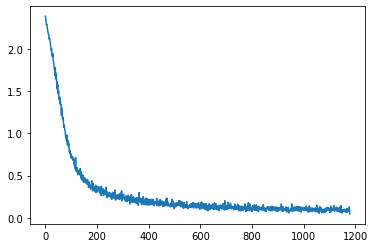

In [9]:
from matplotlib import pyplot as plt
import numpy as np

train_loss = [t.cpu() for t in train_loss]
plt.plot(np.arange(len(train_loss)), train_loss)

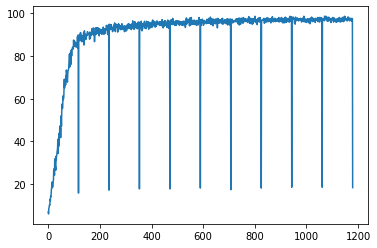

In [10]:
train_accu = [t.cpu() for t in train_accu]
plt.plot(np.arange(len(train_accu)), train_accu)

In [11]:
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        prediction = output.data.max(1)[1]
        correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 97.57%
